In [3]:
import numpy as np
import plotly.express as px
import math
import plotly.figure_factory as ff
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import geom

In [4]:
def simulador(lambda_=1, mi_=2, tempo_total_simulacao=10000, deterministico=False):
    n = tempo_simulacao = num_chegadas = tempo_ocupado_servidor = 0
    clientes_fila, chegadas, freq_clientes, tempo_clientes_fila, tempo_clientes_sistema, tempo_espera_sistema = [], [], [], [], [], []
    
    exponential = (lambda mi: 1 / mi) if deterministico else (lambda mi: np.random.exponential(scale=1 / mi))

    while tempo_simulacao < tempo_total_simulacao:
        tempo_chegada = np.random.exponential(scale=1 / lambda_)
        tempo_saida = exponential(mi_)
        last_event_time = tempo_simulacao

        if n == 0 or tempo_chegada < tempo_saida:
            if n == 0:
                freq_clientes.append(len(clientes_fila))

            tempo_simulacao += tempo_chegada
            num_chegadas += 1
            tempo_clientes_sistema.append((tempo_simulacao - last_event_time) * n)
            tempo_clientes_fila.append((tempo_simulacao - last_event_time) * len(clientes_fila))
            chegadas.append(tempo_simulacao)
            n += 1

            if n > 1:
                clientes_fila.append(tempo_simulacao)
                tempo_ocupado_servidor += tempo_chegada
                freq_clientes.append(len(clientes_fila))

        else:
            tempo_simulacao += tempo_saida
            tempo_clientes_sistema.append((tempo_simulacao - last_event_time) * n)
            tempo_clientes_fila.append((tempo_simulacao - last_event_time) * len(clientes_fila))

            if len(clientes_fila):
                clientes_fila.pop(0)

            tempo_espera_sistema.append(tempo_simulacao - chegadas.pop(0))
            tempo_ocupado_servidor += tempo_saida  
            n -= 1
    
    soma_tempo_clientes_fila = sum(tempo_clientes_fila)
    soma_tempo_clientes_sistema = sum(tempo_clientes_sistema)

    Wq = soma_tempo_clientes_fila / num_chegadas
    W = soma_tempo_clientes_sistema / num_chegadas
    L = soma_tempo_clientes_sistema / tempo_simulacao
    Lq = soma_tempo_clientes_fila / tempo_simulacao
    rho = tempo_ocupado_servidor / tempo_simulacao  
    pi = Counter(freq_clientes)

    for valor, freq in pi.items():
        pi[valor] = round(freq / num_chegadas, 6)

    results = {
        'Total de Clientes': num_chegadas,
        'Clientes Restantes': n,
        'Tempo Total': tempo_simulacao,
        'Tempo Espera Sistema': tempo_espera_sistema,
        'Wq': Wq,
        'W': W,
        'L': L,
        'Lq': Lq,
        'rho': rho,
        'pi': pi,
    }

    return results

In [5]:
def geo(p,k):
    return (1 - p) * p ** k

# M/M/1 Básica e Variantes (20 pontos)

## Cenário 1:  $λ= 1, μ= 2, ρ= 0.5$

In [6]:
result = simulador(lambda_=1, mi_=2, tempo_total_simulacao=10000, deterministico=False)

### CDF Número de clientes no sistema

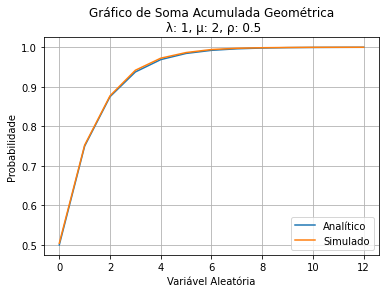

In [7]:
# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y, label='Analítico')
plt.plot(result['pi'].keys(), cumulative_sum, label='Simulado')
# plt.fill_between(x, y, cumulative_sum - 5.1, cumulative_sum + 5.1, color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend()
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


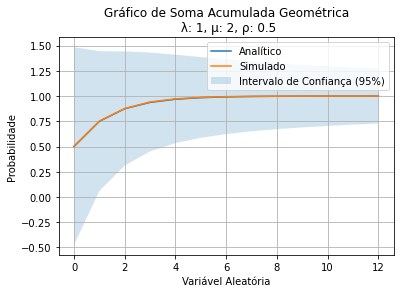

In [8]:
# Função para calcular o intervalo de confiança
def confidence_interval(p, n, alpha=0.05):
    z = 1.96  # Valor crítico para um intervalo de confiança de 95% (aproximadamente)
    std_error = np.sqrt(p * (1 - p) / n)
    margin_error = z * std_error
    return margin_error

# Valores Simulador
pi = result['pi']
cumulative_sum = np.cumsum(list(pi.values()))

# Valores Analíticos
p = 0.5
x = np.arange(0, len(pi))
y = np.cumsum(geo(p, x))

# Plotagem
plt.plot(x, y)
plt.plot(result['pi'].keys(), cumulative_sum)
plt.fill_between(result['pi'].keys(), cumulative_sum - confidence_interval(p, x+1), cumulative_sum + confidence_interval(p, x+1), alpha=0.2)
plt.xlabel('Variável Aleatória')
plt.ylabel('Probabilidade')
plt.legend(['Analítico', 'Simulado', 'Intervalo de Confiança (95%)'])
plt.title(f'Gráfico de Soma Acumulada Geométrica\n λ: {1}, μ: {2}, ρ: {0.5}')
plt.grid(True)
plt.show()


### CDF Tempo de espera dos clientes no sistema (fila de espera + servidor)

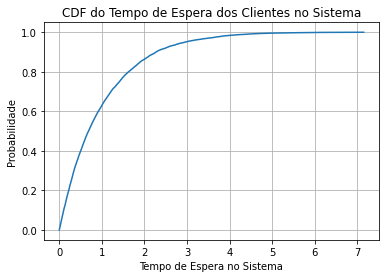

In [9]:
result['Tempo Espera Sistema'].sort()
probabilidade_acumulada = np.arange(1, len(result['Tempo Espera Sistema']) + 1) / len(result['Tempo Espera Sistema'])

plt.plot(result['Tempo Espera Sistema'], probabilidade_acumulada)
plt.xlabel('Tempo de Espera no Sistema')
plt.ylabel('Probabilidade')
plt.title('CDF do Tempo de Espera dos Clientes no Sistema')
plt.grid(True)
plt.show()

### Métricas

In [13]:
def valor_analitico(lambda_, mu_):
    W = 1/(mu_-lambda_)
    Wq = W - (1/mu_)
    L = lambda_*W
    Lq=lambda_*Wq
    Rho = lambda_/mu_
    return [L, Lq, W, W, Rho]

In [20]:
# Index
indices = ['Tempo médio do cliente no sistema (L)',
           'Tempo médio de cliente na fila (Lq)',
           'Número médio de clientes no sistema (W)',
           'Número médio de clientes na fila (Wq)',
           'Probabilidade do sistema ocupado (p)']

# Valor Simulado
data_simulado = [
        result['L'],
        result['Lq'],
        result['W'],
        result['Wq'],
        result['rho']]

def custom_round(value):
    return round(value, 2)
data_simulado = [custom_round(value) for value in data_simulado]

# Valor Analitico
data_analitico = valor_analitico(1,2)

df = pd.DataFrame({'Simulado': data_simulado, 'Analítico': data_analitico}, index=indices)
df

,Simulado,Analítico
Tempo médio do cliente no sistema (L),0.98,1.0
Tempo médio de cliente na fila (Lq),0.48,0.5
Número médio de clientes no sistema (W),0.99,1.0
Número médio de clientes na fila (Wq),0.49,1.0
Probabilidade do sistema ocupado (p),0.50,0.5


## Visualizações e Intervalo de Confiança

Vamos verificar o intervalo de confiança para o tempo médio do cliente no sistema.

In [8]:
def get_z_score(confidence_level):
    if confidence_level == 0.9:
        return 1.645
    elif confidence_level == 0.95:
        return 1.96
    elif confidence_level == 0.99:
        return 2.58

In [20]:
def simulator_confidence_interval(lambda_, mi_, sample_size, conf_level, tempo_total_simulacao = 1000, nome='Lq', deterministico=False):
    # coletar amostra
    results = [simulador(lambda_, mi_, tempo_total_simulacao, deterministico)[nome] for _ in range(sample_size)]

    # calcular intervalo de confiança
    x_barra = np.mean(results)
    z = get_z_score(conf_level)
    s = np.std(results, ddof=1) # ddof=1 para usar o desvio padrão amostral
    limite_inferior = x_barra - z*s/math.sqrt(sample_size)
    limite_superior = x_barra + z*s/math.sqrt(sample_size)

    print(f"Intervalo de confiança de {nome} a {conf_level*100:.0f}%: \nInferior:{limite_inferior:.2f}\nSuperior: {limite_superior:.2f}")

    return (limite_inferior, limite_superior), results

In [54]:
opcao = 'Lq'
intervalo, data = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95, nome=opcao)

Intervalo de confiança de Lq a 95%: 
Inferior:0.49
Superior: 0.50


In [28]:
fig = ff.create_distplot([data], [opcao], curve_type='normal', bin_size=0.006)
fig.show()

In [29]:
fig = px.histogram(data, marginal="box")
fig.show()

## Remoção de  outliers

In [30]:
q1 = np.quantile(data, 0.25)
q3 = np.quantile(data, 0.75)
iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)

data_without_outliers = [x for x in data if (x >= lower_bound) and (x <= upper_bound)]

outlier_percentage = (len(data) - len(data_without_outliers)) / len(data) * 100

print(f"Porcentagem de outliers removidos: {outlier_percentage} %")


Porcentagem de outliers removidos: 1.9 %


In [31]:
fig = ff.create_distplot([data_without_outliers], [opcao], curve_type='normal', bin_size=0.006)
fig.show()

### Salvando informações

In [124]:
# salvando dados para comparação
df = pd.DataFrame(data, columns=['simulador_1'])
df.to_csv('dados/simulador1.csv', index=False)

# Avaliando Resultados

Link para referência: https://people.revoledu.com/kardi/tutorial/Queuing/MM1-Queuing-System.html

$W$ = tempo médio que o cliente permanece no sistema (tempo de espera na fila + tempo de serviço). ${W = \frac{1}{\mu - \lambda}}$.\
$W_q$ = tempo médio que os clientes devem esperar na fila até serem atendidos. ${W_q = W - \frac{1}{\mu}}$.\
$L$ = número médio de clientes no sistema (na fila e sendo servidos). ${L = \lambda W}$\
$L_q$ = número médio de clientes na fila. ${L_q = \lambda W_q}$

### Caso ${\lambda} = 1$ e ${\mu} = 2$

*Tomando uma simulação como exemplo, temos a seguinte saída:*

Total de pessoas que foram ao banco na simulação: ``99388``\
Número de pessoas na fila ao final da simulação: ``1``\
Tempo total da simulação: ``100000.6943``\
Tempo médio do cliente no sistema: ``1.0001``\
Tempo médio de espera na fila: ``0.4995``\
Número médio de clientes no sistema: ``0.9940``\
Número médio de clientes na fila: ``0.4965``

Como vimos mais acima:
${W = \frac{1}{\mu - \lambda}}$. Logo, com ${\lambda = 1}$ e ${\mu = 2}$ temos: ${W = \frac{1}{2 - 1}}$ = 1\
${W_q = W - \frac{1}{\mu}}$. Logo, com ${W= 1}$ e ${\mu = 2}$ temos: ${W_q = 1 - \frac{1}{2}}$ = ${\frac{1}{2}}$\
${L = \lambda W}$. Logo, com ${W= 1}$ e ${\lambda = 1}$ temos: ${L = 1}$\
${L_q = \lambda W_q}$. Logo, com ${W_q= \frac{1}{2}}$ e ${\lambda = 1}$ temos: ${L_q = \frac{1}{2}}$

Os resultados condizem com os valores da simulação!!

In [125]:
_ = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95, name='avg_waiting_time')

Intervalo de confiança de avg_waiting_time a 95%: 
Inferior:0.49
Superior: 0.50


### Caso ${\lambda} = 2$ e ${\mu} = 4$

*Tomando uma simulação como exemplo, temos a seguinte saída:*

Total de pessoas que foram ao banco na simulação: ``200215``\
Número de pessoas na fila ao final da simulação: ``8``\
Tempo total da simulação: ``100000.0323``\
Tempo médio do cliente no sistema: ``0.5056``\
Tempo médio de espera na fila: ``0.2556``\
Número médio de clientes no sistema: ``1.0124``\
Número médio de clientes na fila: ``0.5117``

Como vimos mais acima:
${W = \frac{1}{\mu - \lambda}}$. Logo, com ${\lambda = 2}$ e ${\mu = 4}$ temos: ${W = \frac{1}{4 - 2}} = \frac{1}{2}$\
${W_q = W - \frac{1}{\mu}}$. Logo, com ${W= \frac{1}{2}}$ e ${\mu = 4}$ temos: ${W_q = \frac{1}{2} - \frac{1}{4}}$ = ${\frac{1}{4}}$\
${L = \lambda W}$. Logo, com ${W= \frac{1}{2}}$ e ${\lambda = 2}$ temos: ${L = 2\frac{1}{2} = 1}$\
${L_q = \lambda W_q}$. Logo, com ${W_q= \frac{1}{4}}$ e ${\lambda = 2}$ temos: ${L_q = \frac{2}{4} = \frac{1}{2}}$

Os resultados condizem com os valores da simulação!!

In [126]:
_ = simulator_confidence_interval(lambda_= 2, mi_= 4, sample_size = 1000, conf_level = 0.95, name='avg_waiting_time')

Intervalo de confiança de avg_waiting_time a 95%: 
Inferior:0.25
Superior: 0.25


### Caso ${\lambda} = 1$ e ${\mu} = 4$

*Tomando uma simulação como exemplo, temos a seguinte saída:*

Total de pessoas que foram ao banco na simulação: ``99688``\
Número de pessoas na fila ao final da simulação: ``1``\
Tempo total da simulação: ``100000.4030``\
Tempo médio do cliente no sistema: ``0.3333``\
Tempo médio de espera na fila: ``0.0829``\
Número médio de clientes no sistema: ``0.3323``\
Número médio de clientes na fila: ``0.0826``

Como vimos mais acima:
${W = \frac{1}{\mu - \lambda}}$. Logo, com ${\lambda = 1}$ e ${\mu = 4}$ temos: ${W = \frac{1}{4 - 1}} = \frac{1}{3}$\
${W_q = W - \frac{1}{\mu}}$. Logo, com ${W= \frac{1}{3}}$ e ${\mu = 4}$ temos: ${W_q = \frac{1}{3} - \frac{1}{4}}$ = ${\frac{1}{12}}$\
${L = \lambda W}$. Logo, com ${W= \frac{1}{3}}$ e ${\lambda = 1}$ temos: ${L = \frac{1}{3}}$\
${L_q = \lambda W_q}$. Logo, com ${W_q= \frac{1}{12}}$ e ${\lambda = 1}$ temos: ${L_q = \frac{1}{12}}$

Os resultados condizem com os valores da simulação!!

In [127]:
_ = simulator_confidence_interval(lambda_= 1, mi_= 4, sample_size = 1000, conf_level = 0.95, name='avg_waiting_time')

Intervalo de confiança de avg_waiting_time a 95%: 
Inferior:0.08
Superior: 0.08


### Caso ${\lambda} = 1$ e ${\mu} = 2$ Determinístico

In [128]:
data = simulador(lambda_=1, mi_= 2,simulation_total_time=100000, deterministic=True)

In [129]:
print(f"Total de pessoas que foram ao banco na simulação: {data['number_of_arrivals']}")
print(f"Número de pessoas na fila ao final da simulação: {data['people_in_line']}")
print(f"Tempo total da simulação: {data['simul_time']:.4f}")
print(f"Tempo médio do cliente no sistema: {(data['avg_clients_in_system']):.4f}")
print(f"Tempo médio de espera na fila: {(data['avg_waiting_time']):.4f}")
print(f"Número médio de clientes no sistema: {(data['avg_clients_in_system']):.4f}")
print(f"Número médio de clientes na fila: {(data['avg_clients_in_line']):.4f}")

Total de pessoas que foram ao banco na simulação: 99985
Número de pessoas na fila ao final da simulação: 1
Tempo total da simulação: 100000.9398
Tempo médio do cliente no sistema: 1.8363
Tempo médio de espera na fila: 1.1883
Número médio de clientes no sistema: 1.8363
Número médio de clientes na fila: 1.1881


In [130]:
_ = simulator_confidence_interval(lambda_= 1, mi_= 2, sample_size = 1000, conf_level = 0.95, name='avg_waiting_time', deterministic=True)

Intervalo de confiança de avg_waiting_time a 95%: 
Inferior:1.17
Superior: 1.20
